## Analysis of stock prices using PCA / Notebook 1

In this take-home final you are to analyze the daily changes in stock prices using PCA and to mesure the dimension of stock sequences.

We Start by downloading data and pre-processing it to make it ready for analysis using Spark.

In [1]:
import sys,os
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
%matplotlib inline

from time import time
import math
import pandas as pd
from glob import glob
import pickle


### Stock Info
The file `data/TickerInfo.tsv` contains information relating companies to sectors.

In [2]:
TickerInfo=pd.read_csv('data/tickerInfo.tsv',sep='\t')
print(TickerInfo.shape)
TickerInfo.head()

(505, 5)


Unnamed: 0 Ticker                 Name                  Sector SECTOR_ID
0           0    MMM        3M|3M Company             Industrials      INDS
1           1    ABT  Abbott Laboratories             Health Care        HC
2           2   ABBV          AbbVie Inc.             Health Care        HC
3           3    ACN        Accenture plc  Information Technology        IT
4           4   ATVI  Activision Blizzard  Information Technology        IT

In [4]:
Sectors={'Consumer Discretionary':'CD',
 'Consumer Staples':'CS',
 'Energy':'EN',
 'Financials':'FIN',
 'Health Care':'HC',
 'Industrials':'INDS',
 'Information Technology':'IT',
 'Materials':'MAT',
 'Real Estate':'RE',
 'Telecommunication Services':'TS',
 'Utilities':'UTIL'}

### Stock and sector information
`TickerInfo` is a pandas table containing, for each Ticker, the company name, the sector, and a sector ID. There are 11 sectors. Some, such as `Consumer Discretionary` and `Information Technology` include many stocks while others, such as `Telecommunication Services` include very few.

In [5]:
from collections import Counter
L=list(Counter(TickerInfo['Sector']).items())
print('Sector ID\t\tSector Name\tNo. of Stocks')
print('=========\t\t===========\t=============')
sum=0
for l in L:
    sum+=l[1]
    print('%s\t%30s\t%d\t%d'%(Sectors[l[0]],l[0],l[1],sum))

Sector ID		Sector Name	No. of Stocks
=========		===========	=============
INDS	                   Industrials	66	66
HC	                   Health Care	60	126
IT	        Information Technology	70	196
CD	        Consumer Discretionary	84	280
UTIL	                     Utilities	28	308
FIN	                    Financials	66	374
MAT	                     Materials	25	399
RE	                   Real Estate	31	430
CS	              Consumer Staples	37	467
EN	                        Energy	34	501
TS	    Telecommunication Services	4	505


### Download Data
The data is a directory with .csv files, one for each stock. This directory has been tarred and uploaded to 
S3, at: https://mas-dse-open.s3.amazonaws.com/Stocks/spdata_csv.tgz

Download and untar the file to create a subdirectory of the current directory called `spdata_csv`

In [6]:
!wget https://mas-dse-open.s3.amazonaws.com/Stocks/spdata_csv.tgz

--2020-06-11 09:30:53--  https://mas-dse-open.s3.amazonaws.com/Stocks/spdata_csv.tgz
Resolving mas-dse-open.s3.amazonaws.com (mas-dse-open.s3.amazonaws.com)... 52.218.228.27
Connecting to mas-dse-open.s3.amazonaws.com (mas-dse-open.s3.amazonaws.com)|52.218.228.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108227395 (103M) [application/x-tar]
Saving to: ‘spdata_csv.tgz.2’

spdata_csv.tgz.2    100%[===================>] 103.21M  2.30MB/s    in 61s     

2020-06-11 09:31:55 (1.70 MB/s) - ‘spdata_csv.tgz.2’ saved [108227395/108227395]



In [7]:
!tar xzf spdata_csv.tgz

In [8]:
files=!ls -1 spdata_csv/train/
files[:5]

['A.csv', 'AAPL.csv', 'ABC.csv', 'ABT.csv', 'ACN.csv']

In [9]:
!ls -l spdata_csv/train/ | wc
!ls -l spdata_csv/test/ | wc

     393    3530   21586
      90     803    4809


In [10]:
#change this path to where you stored the raw data   #del Cell
Data_dir='./spdata_csv/'  #del
curr_dir=os.getcwd()      #del
curr_dir                  #del

'/Users/gio/Documents/DSE/2019-rgm001/DSE230/final'

## Read Data and create a single table

Your task in this notebook is to read the sock-information `.csv` files, extract from them the column 
`Adj. Open` and combine them into a single `.csv` file containing all of the information that is relevant for later analysis.

Below we suggest a particular sequence of steps, you can either follow these steps, or do this in your own way.  The end result should be a file called `SP500.csv` which stores the information described below.

### Step 1: files into pandas dataframes

In this step you read all of the relevant information into a large dictionary we call `Tables`.

The key to this dictionary is the stocks "ticker" which corresponds to the file name excluding the `.csv` extension.

You should read in all of the files in the directory `spdata_csv` other than:

* Files for tickers that are not in the list `Tickers`.
* Files for tickers that were listed in the email you got for this final.
As part of the email you got about this final, there is a list of tickers that you should omit from your analysis.

In [11]:
#del the rest of this cell
%cd spdata_csv

/Users/gio/Documents/DSE/2019-rgm001/DSE230/final/spdata_csv


In [12]:
Tables={}
for filename in glob('*/*.csv'):
    print('\r',filename, end=' ')
    code = filename[:-4]
    tbl=pd.read_csv(filename,index_col='Date',parse_dates=True)
    if(np.shape(tbl)[1]==12):
        Tables[code]=tbl.sort_index()
        Tables[code]
    else:
        print(filename,np.shape(tbl))

%cd ..

 train/PPL.csv   /Users/gio/Documents/DSE/2019-rgm001/DSE230/final


In [13]:
# Example of an entry in `Tables`
print(len(Tables))
Tables['train/IBM'].head()

481


Open   High    Low   Close       Volume  Ex-Dividend  \
Date                                                                
1962-01-02  578.5  578.5  572.0  572.00  5162.666667          0.0   
1962-01-03  572.0  577.0  572.0  577.00  3840.000000          0.0   
1962-01-04  577.0  577.0  571.0  571.25  3413.333333          0.0   
1962-01-05  570.5  570.5  559.0  560.00  4842.666667          0.0   
1962-01-08  559.5  559.5  545.0  549.50  7253.333333          0.0   

            Split Ratio  Adj. Open  Adj. High  Adj. Low  Adj. Close  \
Date                                                                  
1962-01-02          1.0   5.180989   5.180989  5.122776    5.122776   
1962-01-03          1.0   5.122776   5.167555  5.122776    5.167555   
1962-01-04          1.0   5.167555   5.167555  5.113820    5.116059   
1962-01-05          1.0   5.109342   5.109342  5.006349    5.015305   
1962-01-08          1.0   5.010827   5.010827  4.880966    4.921268   

            Adj. Volume  
Date                     
1962-01-02     387200.0  
1962-01-03     288000.0  
1962-01-04     256000.0  
1962-01-05     363200.0  
1962-01-08     544000.0

### Step 2: Computing diffs and combining into a single table

The next step is to extract from each table the relevant prices, compute an additional quantity we call `diff` and create a single combined pandas dataframe.

The price we ue is the **Adjusted Open Price** which is the price when the stock exchange opens in the morning. We use the **adjusted** price which eliminates technical adjustments such as stock splits.

It is more meaningful to predict *changes* in prices than prices themselves. We therefor compute for each stock a `Diffs` sequence in which $d(t)=\log \frac{p(t+1)}{p(t)}$ where $p(t)$ is the price at time $t$ and $d(t)$ is the price diff or the price ratio.

Obviously, if we have a price sequence of length $T$ then the length of the diff sequence will be $T-1$. To make the price sequence and the diff sequence have the same length we eliminate the last day price for each sequence.

Your task in this step is to join the stock tables by date, compute the diff seqeunce, and create one large Pandas DataFrame where the row index is the date, and there are two columns for each ticker. For example for the ticker `IBM`, there would be two columns `IBM_P` and `IBM_D`. The first corresponds to the prices of the IBM stock $p(t)$ and the second to the price difference $d(t)$

In [14]:
Diffs=pd.DataFrame()
# Remove the following lines to process all stocks. Plot the PCA and the time sequences of these stocks 
# to see why they are outliers and need to be removed.
Indices=set(Tables.keys())      #remove outlier stock - most likely due to file errors
print(len(Indices))
i=1
for code in Indices:
    print('\r',i,code, end=' ')
    i+=1
    tbl=Tables[code]
    S=tbl['Adj. Open']
    prices=np.array(S)  # The length of "prices" will remain the original length.
    diff=np.log(prices[1:]/prices[:-1])
    I=S.index[:-1]
    #print np.shae(Diffs),np.shape(Sdiff),np.shape(diff),len(I)
    Sdiff=pd.DataFrame({code+'_D':diff,code+'_P':prices[:-1]},index=I)
    Diffs=Diffs.join(Sdiff,how='outer')
#rm above
Diffs.head()

481
 481 train/VRSN  

train/BIIB_D  train/BIIB_P  train/MO_D  train/MO_P  train/FAST_D  \
Date                                                                           
1962-01-02           NaN           NaN         NaN         NaN           NaN   
1962-01-03           NaN           NaN         NaN         NaN           NaN   
1962-01-04           NaN           NaN         NaN         NaN           NaN   
1962-01-05           NaN           NaN         NaN         NaN           NaN   
1962-01-08           NaN           NaN         NaN         NaN           NaN   

            train/FAST_P  train/NUE_D  train/NUE_P  test/43_D  test/43_P  ...  \
Date                                                                      ...   
1962-01-02           NaN          NaN          NaN        NaN        NaN  ...   
1962-01-03           NaN          NaN          NaN        NaN        NaN  ...   
1962-01-04           NaN          NaN          NaN        NaN        NaN  ...   
1962-01-05           NaN          NaN          NaN        NaN        NaN  ...   
1962-01-08           NaN          NaN          NaN        NaN        NaN  ...   

            train/TXT_D  train/TXT_P  test/48_D  test/48_P  test/23_D  \
Date                                                                    
1962-01-02          NaN          NaN        NaN        NaN        NaN   
1962-01-03          NaN          NaN        NaN        NaN        NaN   
1962-01-04          NaN          NaN        NaN        NaN        NaN   
1962-01-05          NaN          NaN        NaN        NaN        NaN   
1962-01-08          NaN          NaN        NaN        NaN        NaN   

            test/23_P  train/AMT_D  train/AMT_P  train/VRSN_D  train/VRSN_P  
Date                                                                         
1962-01-02        NaN          NaN          NaN           NaN           NaN  
1962-01-03        NaN          NaN          NaN           NaN           NaN  
1962-01-04        NaN          NaN          NaN           NaN           NaN  
1962-01-05        NaN          NaN          NaN           NaN           NaN  
1962-01-08        NaN          NaN          NaN           NaN           NaN  

[5 rows x 962 columns]

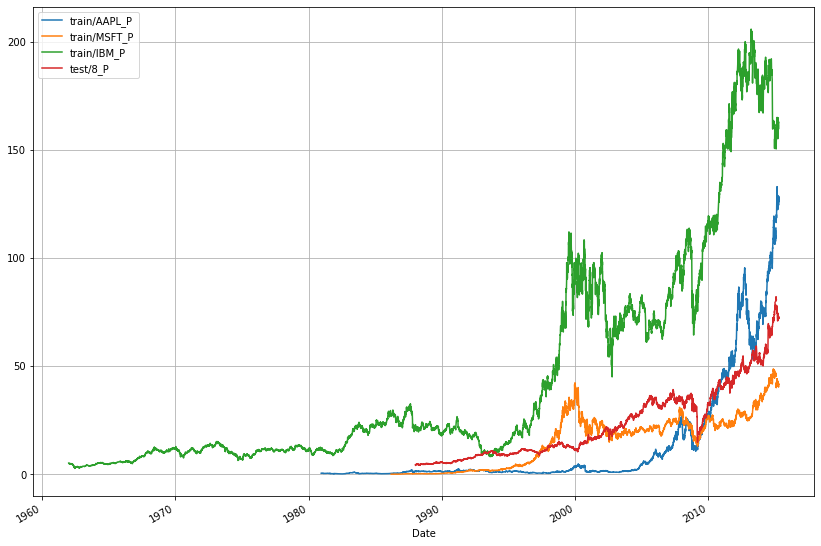

In [15]:
# plot some stocks
Diffs[['train/AAPL_P','train/MSFT_P','train/IBM_P','test/8_P']].plot(figsize=(14,10));
plt.grid()

### Black Monday

One of the biggest crashes in the US stock market happened on
**Black Monday:** Oct 19 1987  

We will look at the stocks around that date

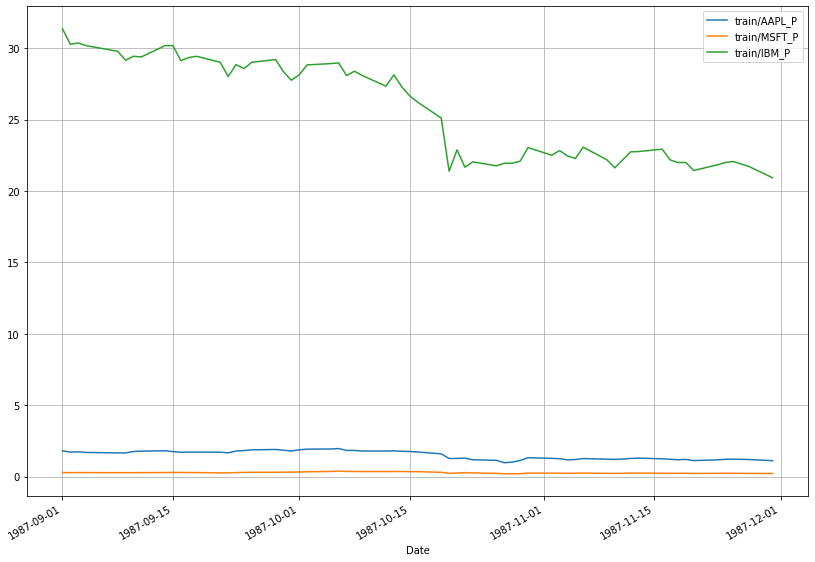

In [16]:
#Focus on "Black Monday:" the stock crash of Oct 19 1987

import datetime
format = "%b-%d-%Y"

_from = datetime.datetime.strptime('Sep-1-1987', format)
_to = datetime.datetime.strptime('Nov-30-1987', format)

Diffs.loc[_from:_to,['train/AAPL_P','train/MSFT_P','train/IBM_P']].plot(figsize=(14,10));
plt.grid()

**Why does it seems that the price of IBM fell much more than those of Apple and microsoft?**

Because IBM's price started so much higher. As explained above it is more informative to consider $\log(p_{t+1}/p_t)$

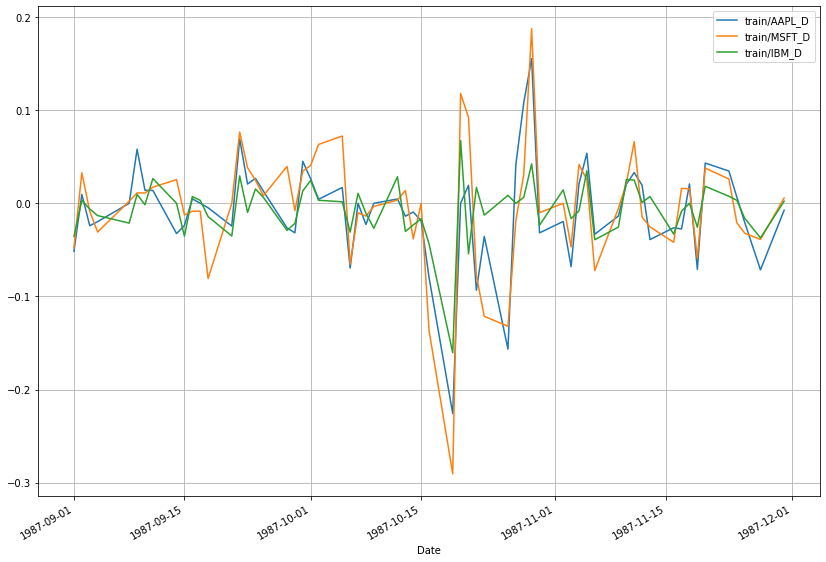

In [17]:
Diffs.loc[_from:_to,['train/AAPL_D','train/MSFT_D','train/IBM_D']].plot(figsize=(14,10));
plt.grid()

### Extract tickers

Complete the following function to extract the tickers (company names) from the column names of the dataframe `df`. The tickers can be obtained by removing the `train/` and `test/` prefix and the `_D` or `_P` suffix from the `df` column names

Input: `df` dataframe read in 1.2

Returns: `tickers` - list of tickers

Example Output:

   ['RF',
  'TIF',
  'HAL',
  'KSS',
  'INTU',
  'LH',
  ]

In [18]:
def partition_columns(df):
    """Partition columns of df into train set and test set
    Each of them sorted lexicographically."""
    
    ### Your code here
    
    # get train list
#     train_col = sorted(list(set([i.split('/')[1].split('_')[0] for i in df.columns if 'train' in i])))
    train_col = sorted([i for i in df.columns if 'train' in i])

    
    # get test list
#     test_col = sorted(list(set([i.split('/')[1].split('_')[0] for i in df.columns if 'test' in i])))
    test_col = sorted([i for i in df.columns if 'test' in i])
    
    return  train_col+test_col

columns = partition_columns(Diffs)

In [19]:
Diffs=Diffs[columns]

In [20]:
columns[:6],columns[-5:]

(['train/AAPL_D',
  'train/AAPL_P',
  'train/ABC_D',
  'train/ABC_P',
  'train/ABT_D',
  'train/ABT_P'],
 ['test/88_P', 'test/8_D', 'test/8_P', 'test/9_D', 'test/9_P'])

In [21]:
Diffs.columns[:5],Diffs.columns[-5:]

(Index(['train/AAPL_D', 'train/AAPL_P', 'train/ABC_D', 'train/ABC_P',
        'train/ABT_D'],
       dtype='object'),
 Index(['test/88_P', 'test/8_D', 'test/8_P', 'test/9_D', 'test/9_P'], dtype='object'))

In [27]:
## visible tests.
assert len(columns) == 962, 'Incorrect number of columns'
assert len([a for a in Diffs.columns if '_D' in a]) == 481, 'Incorrect number of diff columns'
assert Diffs.shape == (13422, 962), 'Incorrect data shape'

In [23]:
#(5 points)
# HIDDEN TESTS

In [24]:
#%cd ..
Diffs.to_csv('data/SP500.csv')

### Note

In order to make sure errors in constructing data do not get propagated in other notebooks of the final, you may run the below cell which will download the instructors version of "SP500.csv". For next notebooks, you may use either your own version or the one provided by us. Ideally both should have the same contents

In [25]:
%mkdir -p data/
%cd data
!rm -f data.tgz && rm -rf data ## Instructor's version of the output from this notebook
!wget https://mas-dse-open.s3.amazonaws.com/Stocks/data.tgz
!tar -xf data.tgz ## Extracting data
%cd ../ 
## Going back to `Final` directory to keep it as our working directory
%ls -al data/

## Now the `data` folder should have another `data` folder which contains the instructors version of SP500.csv

/Users/gio/Documents/DSE/2019-rgm001/DSE230/final/data
--2020-06-11 09:34:13--  https://mas-dse-open.s3.amazonaws.com/Stocks/data.tgz
Resolving mas-dse-open.s3.amazonaws.com (mas-dse-open.s3.amazonaws.com)... 52.218.197.155
Connecting to mas-dse-open.s3.amazonaws.com (mas-dse-open.s3.amazonaws.com)|52.218.197.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52006823 (50M) [application/x-tar]
Saving to: ‘data.tgz’

data.tgz            100%[===================>]  49.60M  1.97MB/s    in 24s     

2020-06-11 09:34:38 (2.06 MB/s) - ‘data.tgz’ saved [52006823/52006823]

/Users/gio/Documents/DSE/2019-rgm001/DSE230/final
total 372360
drwxr-xr-x@ 10 gio  staff        320 Jun 11 09:34 ./
drwxr-xr-x@ 19 gio  staff        608 Jun 11 09:33 ../
-rw-r--r--@  1 gio  staff       8196 Jun 10 14:33 .DS_Store
drwxr-xr-x@  2 gio  staff         64 Jun  2 15:26 .ipynb_checkpoints/
-rw-r--r--   1 gio  staff    1864236 Jun  8  2018 PCA.pickle
-rw-r--r--@  1 gio  staff    1864236 Ju

In [26]:
## How different is your version than the instructors? (Not for grading only for self evaluation)
!diff data/SP500.csv data/data/SP500.csv

390c390
< 1963-07-17,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.0,0.33744397281676003,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.0,2.468898504589,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,-0.0073183808076856555,5.7011783037075,,,,,,,,,,,,,,,-0.019418085857101627,0.08291858207843737,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.003159560290361214,0.48707186026037996,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.011299555253934125,0.12010554312327001,,,,,,,,,,,,,,,-0.005182850645799869,3.8981164111867006,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.013280407667899069,0.7267335984751501,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

> 1984-10-30,0.0,0.41326583581314,,,0.008929708184794296,1.9277793949813,,,,,0.0,2.2041055614623,0.015037877364530659,1.6756656207863,-0.010287042530132491,7.572055674384,,,,,0.018106685036284275,3.1754655135089,,,0.013793322132336864,3.8574282398973,0.011954165342730898,0.54608628489766,,,0.017009516738443056,10.93062187326,,,,,,,,,,,0.0,0.15741574146663,0.03125254350410453,15.75,0.0,0.09243768515099302,,,,,,,,,0.013245226750014149,3.6021998689668,-0.01177638732382496,3.632467252877831,,,0.02234729869200791,3.4098166575548,,,,,-0.003992021269537115,4.0865057803989,0.0036046067034400807,104.13053720581,,,,,,,0.026784083906829292,3.847556676123,0.015559012600303741,5.3639087592455,,,,,,,0.00543972329579935,2.1675253404641004,0.013793322132332484,1.6766186309643998,0.0,0.040458554658056,,,,,-0.015384918839527483,1.7408858125243998,,,0.033818464142921445,2.1750921847283,0.005115100666769305,2.7727989332555003,,,,,,,-0.015823512371752006,2.8836510868287997,,,-0.0042187309040550265,2.643158

> 1987-06-18,0.030583423372096123,1.3309752217061999,,,0.017281713849309786,6.0174187812549995,,,-0.013245226750020567,1.1769315790522747,-0.006478966097713133,2.6003601437207995,-0.016565330846379074,3.8938345789305,0.01235321546948042,20.396783692871,-0.030153038170687443,3.068158487473262,,,-0.00437318481222031,5.5521755747824,,,0.0021422105909912744,6.6033259960059,0.008534902449837727,1.4183886055966002,,,0.006968669316113722,24.035142073586,,,,,,,,,,,-0.011428695823606573,0.28562031441367997,-0.006018072325563021,10.0,0.03871451218069192,0.73950148120794,,,,,,,,,-0.009389740349834436,5.139138479726,-0.011100946559446219,3.970685204432912,-0.004454350349382428,6.5693070089519,-0.007718824179736313,7.485684399239401,,,,,-0.014266677298481488,7.087618259231,-0.014033348458976108,209.32452076438,,,,,0.0,4.0748188346914,0.0216177895323161,6.6426956596440005,0.0051948168771074645,6.973589519822201,,,,,0.020202707317517294,0.37447728834681,0.03174869831457683,9.2118985396118,0.014074486

< 1989-09-28,0.005540180375609389,1.4952613703236002,,,0.027671937203326988,5.8567970721949,,,0.05556985115481057,1.0840159280744637,0.012232568435600014,1.2594888922642,0.011721978033799534,6.145650777740201,0.013602714331157775,18.869380585599,0.031748698314580485,4.710217998714574,,,0.0,7.3469139993802,,,0.013039832345375972,6.2373843926938,0.027779564107098347,1.8080062414456002,0.01954115520681738,4.248882823129,0.020101179321059447,33.810430222293,,,,,,,,,,,0.01941808585710391,0.33105990988859,0.014747856634555679,4.375,0.005899722127192737,0.82220888371146,,,,,,,,,0.0,6.6680263354683,0.008704440630146538,5.6259462336307315,0.019129169908990815,7.3756290089403995,-0.0010358458061199268,7.240750363107799,,,,,0.0,7.740352310205599,0.0,214.33153556408,,,,,0.012100406934086172,8.2722412697995,0.0,6.8391185549055,-0.004173919103133815,12.722713893482,,,,,0.0,0.17577505371381,0.028586547761424462,8.5726360699421,0.0023137858502632644,5.275333487425099,-0.006250801700480819,1.3545919607

> 1990-08-08,0.01880933195751416,1.3152989564134,,,0.0029585820397481405,7.617561859635,,,0.0083682496705168,1.8434364379824533,0.0,0.8396592615094499,0.010206253119194481,7.169663449982701,-0.002596625847269245,20.585300855279,0.020408871631207033,5.897482357004434,,,0.013423020332134635,7.3225892066775,,,0.015504186535963287,5.3462810570247,0.06453852113761217,1.5308566473769998,0.02501776297527863,3.4109156721683997,-0.014493007302573397,30.00376972822,,,,,,,,,,,0.03226086221822534,0.39597361770988004,0.0,2.75,0.03647820860238612,1.5714406475669,,,,,,,,,-0.01486795155015846,6.7489833324517,-0.044111826632409624,6.612813578473573,-0.020414502055768922,8.2938872054838,0.002427185657615346,7.8454997510913005,,,,,-0.005730674708985877,5.852360968684,0.014372410788218232,157.4436161314,,,,,-0.00705885283961552,5.4864819470881,0.020301143817856762,7.3116651855206,0.019048194970692232,17.308926592622,,,0.022472855852061616,2.7990161851648,0.04194875520284251,0.27115212633765,0.044902546620

< 1991-04-19,-0.02489755162172834,2.0355367867199,,,-0.02898753687324864,9.891843611672199,,,-0.03063696946189003,3.5942754258435863,-0.03250927856528006,1.5346387733433997,-0.010695289116751957,7.2658593432076,-0.010695289116762057,28.981039537086,0.013544225107757034,6.691178552910613,,,0.008368249670522744,8.0859261722592,,,-0.008548644114680433,5.4285728079619,-0.029806128032693013,2.6464565288837,0.0,5.4495205943488,-0.02304839543628068,43.018235022723,,,,,,,,,,,-0.0068259650703903696,0.47711575248649,-0.0088496152769825,6.81,-0.001974334303722969,4.9332533022688,,,,,,,,,-0.009503089367271383,7.8475449001110995,-0.017699577099400975,5.454176473452586,-0.013245226750024392,6.552938481279299,0.02646657318821647,10.418626480187,,,,,0.015631745691694187,6.8070911957383,-0.04009126741429631,172.24946135771998,0.007843177461025879,7.9375,,,-0.009382597041982953,6.4323220907364,-0.020619287202750664,11.112616597368,-0.010638398205054295,15.847554995561,,,-0.022989518224665318,2.799016185

> 1992-05-06,0.012270092591807603,2.0318924320589,,,-0.013295255516585539,12.579614158712001,,,-0.005221943981151489,2.9756861992576895,-0.03777785213901086,1.3240780662263998,0.025522957231089674,8.0953039577323,0.010609053461872525,38.640235930984,0.014493007302567043,4.1731017423017915,,,-0.004086128583304403,9.559417774693301,-0.048790164169414105,5.0188948666182,-0.008901778979458434,4.7304514749191,-0.0046123906500036204,2.8943898343442003,-0.03174869831456563,5.496593565564099,-0.004513607852882014,37.205715300862,,,,,,,,,,,0.013605652055780432,0.47387006709542995,-0.006688988150796652,9.0,-0.00881062968216444,6.6555133308715,,,,,,,0.029716472328477087,3.908621390809272,0.0029670226034032364,8.910087609541801,0.0,6.3661695784579715,-0.010471299867291664,5.462609981109201,0.005445039631047226,15.308686676792,0.0,0.46930456059434994,,,-0.004673745699879484,7.9958535727923,-0.011049836186616141,139.01711861817,0.016843647329554002,18.25,,,-0.002670228555882483,7.9872114349768,-0.01

> 1993-10-04,0.01665974524118291,0.7595151670147701,,,0.0,10.357805234576,,,0.0,2.3270326144161766,0.01851904776724734,3.4555208069812,-0.005859831958121826,7.9526893907039,0.0025837239852864622,41.555054604309,0.013720064742463947,5.479122469055677,,,-0.00316289140852479,12.416088928917999,0.007662872745559622,5.1939202124485,0.0,6.8459709118926,-0.004102893557374492,4.0777975221795,0.0,5.042336775649099,0.0025542798051031235,65.766464178208,,,,,,,0.0,10.166990018527,,,0.043124426633765034,1.9149543807281002,-0.044001647437634774,13.125,0.01869213301214056,4.6413448228446,,,,,,,-0.06859831634275221,1.641439609597397,-0.009030222100484757,11.472733088139,-0.008163310639160981,11.964191244123368,0.05812774161784664,10.990277161433001,-0.009821738298523636,12.695125014563999,-0.008608374536593444,0.8477759804285,,,0.013736989730184467,7.8527744953108005,0.003386007749736713,219.36053661191002,0.037187829406035475,24.81,,,0.014476443286794403,8.6441046213363,-0.02779201732965631,7.4149338

< 1994-11-28,0.010050335853540855,1.2686762335153,,,0.0,12.108978115669,,,0.0377403279828469,4.0371039008052065,0.0,4.344267840702,-0.013127738645590342,10.169932919951,0.00446389456534831,46.318864876927,0.09002615165771961,8.43347125089389,,,0.0,11.813204106617999,0.013986241974747316,4.269620515419,0.008421581581667139,5.041624824304,0.003523198007299841,4.3791773672412,0.02763812282014279,6.282269545797599,0.01224085045495165,62.877239259477996,-0.01459879942116638,3.8338552726823996,,,,,0.010947477755174989,7.517692683891901,,,0.01932427282639043,2.661462020673,0.009756174945364656,12.75,0.004514680354539212,6.4511773952745,,,,,,,0.0,1.7003863359089058,0.03200273108616728,9.6792009529747,0.014761887850390183,9.726189070046766,-0.008823235968907942,9.635378882428599,0.014191128519524475,14.313779660733,-0.005458758043716382,1.4460636009023002,-0.006644542718669284,8.334873663404599,-0.02004202602851285,9.4690798604592,0.004434597067844111,24.203203581718,0.03102289601199397,24.12,,

> 1995-09-20,-0.02033968423712052,1.2587913887362,0.0,3.0305050841896004,-0.008743999939423633,16.333198397785,,,-0.01627856886138536,6.772825718752532,0.0068728792877620504,7.0240726683964,0.0,8.8422731320805,-0.008896600507752466,58.162012579229,-0.00503779402995707,12.174539887928786,,,0.007168489478571051,13.114973060123,0.013245226750005385,4.5101625162877,-0.00714288751238112,8.1333455702246,0.0029311208088549623,5.273695621031701,0.007843177461024997,7.3774176811913,0.014662159328556633,88.060187219319,0.012530284425632148,4.895635464941299,,,,,-0.003422707277562106,11.333553789772001,,,-0.01438873745209032,5.4527514569885005,-0.007326040092072898,17.125,-0.002609657207223973,11.648315962943,,,,,,,-0.005375245524507424,10.995831638877592,-0.0032757998299136237,12.666698323067,-0.004315001301413236,10.932687771060117,-0.007804516919855307,11.20090471689,-0.011234037334734675,18.451197999398,-0.010810916104168481,1.407913681783,0.0,9.8896127904635,0.005853675251403775,12.368043380

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



44364,0.010418511311842106,23.825479695300004,0.0012514079971181046,39.446510916567995,-0.018877719236436826,577.52,-0.008129391712775004,51.946305548912,-0.032435275753170706,24.116872707076997,-0.03896394392017934,30.686900261763,-0.02027332629286755,43.35,0.004419199111173056,58.068066138382996,-0.018018505502680058,20.541008542038,-0.03722775671982118,40.058111441617996,-0.016463510706794915,52.754960254273,-0.03174869831458649,7.525893489995401,-0.002686007524109369,16.531810400068,-0.022876505701921557,49.647591730003995,-0.001843075824523333,69.945807001369,-0.02505982713618819,32.31754171782,-0.004475710796241634,31.35,0.0002703798853765185,33.760038182932,-0.004308494385702212,22.182669728818002,-0.010722898612279782,47.268390394392995,-0.04133289766878172,49.141977389399,-0.004804551718741924,20.583976717006,0.011182452135041505,24.660759022365998,-0.022041337654572817,88.99,-0.0023008350673544456,65.457544832282,0.0027676454954115044,35.828230420766,-0.005098658795446753,80.

< 2012-06-13,-0.00572547297889687,77.719474981028,-0.0038012535589859063,35.670098029064995,-0.0021085077960193645,58.361889457623995,-0.006629472989293003,56.144833140192006,-0.009523881511255366,31.65,-0.009735068770764686,34.79632910501,-0.017408257306620267,30.110110071753002,-0.0003730647310554906,50.31435738127,-0.009719468268415994,32.05,0.005166399578543794,29.626868612163,0.0052970233578869454,35.681288665036995,0.012997745941973646,11.767314682496,-0.01680711831638219,40.918968908218005,-0.0017311739206682987,38.220877732895005,-0.002741380081872947,90.895936618498,0.00861217644935569,29.729704112224997,-0.007061913756474144,24.901877308786002,0.007168489478592876,31.693791390387002,-0.019424589308808488,30.15,0.002050681837736136,32.29102069278,-0.018649815589156266,93.63,-0.000927213789137243,10.154179913842,-0.024056142854236268,5.89,0.002180074985953872,65.548055632053,-0.012149290620790641,45.301398891011,0.0012101045191584738,63.252947209746,-0.0012071128259017302,215.5

> 2012-08-08,0.0017706667064623241,83.789364353719,-0.018807716564740545,37.874104086145,-0.003799107981034097,62.576877086534004,0.0152224888870293,59.190770879671,0.012656443061945353,32.19,-0.0004993757906619426,37.511866091138,0.03029953741724734,24.261927412696,0.003490404939774763,53.673652409709995,0.0005683432946394272,35.18,0.00029040220908631097,31.080228102278,0.0172805815094916,38.212353549331,0.014636507522769784,11.093797080063,0.008581441774242048,35.830416415209,0.0,42.688007747142,0.0005864758833267922,84.834216798013,0.006504591618995271,31.826409791464,-0.011811911003635866,24.348502257479,0.008871696668970183,34.116428322206,0.00220750641521052,36.2,0.006562564568430036,35.955720108647,-0.007627802048886127,105.28,0.011834457647020572,11.067020925559001,0.08515780834030696,4.05,-0.001973360285166623,77.40259268292401,0.007208237476311333,51.194130609806,-0.00781864811778938,67.822408139703,-0.0057968705870088955,235.29,0.015030215439328429,38.96,0.009030293010067785

> 2012-08-24,0.030580957134981945,89.597567808164,0.005789489855258305,36.7539393135,0.01069692351360994,61.779598506939,0.01621524350125602,59.122432532952004,-0.0033820170591444217,32.58,0.008572921894996342,36.978122614554,0.007228488769579363,24.91147036548,0.009446184452053195,54.377415334663,0.08429645669501148,27.97,0.0036242866612569446,29.834491396465,0.006566627723885912,38.778056968639,0.011358794035632292,10.949471879542001,-0.012569102242619761,37.856914515719,0.017191153432887334,43.339660962751,0.011182507205573289,84.136265883223,0.03170209716910489,33.161576143809995,0.00896197185725957,24.778169140945,0.013206354813614436,32.358593498514,0.005923549900047071,37.03,0.004773278752665546,35.624287344938004,0.026533818536437635,103.76,0.005102051883853799,11.123125824876,0.017880425277848583,3.88,0.01036649140466878,79.967850158497,0.018449696765714525,51.507505922387,0.007220247973487759,66.26658399376299,0.016862975743416345,241.68,0.02340161557708171,39.7,0.00554441722

> 2012-08-30,-0.005067692044972636,91.109631203268,0.015839824312276318,36.453234082907,0.0021396920894617218,62.035866621809,0.013721221479797307,59.356735435988,-0.003784299691239618,31.77,0.00101317131262233,37.230521977522,0.00829567351679426,25.120730521281,0.003947486461281481,54.565085447983996,-0.0009729204594271175,30.85,0.003942385697507882,29.708112310367998,0.004423240828294477,39.106529921785004,-0.0034904049397692706,11.045688679889999,0.0020565559947469366,37.499864850391,0.006493529310546105,43.80578110919001,0.016174754881372856,84.28565555986201,0.013300033497503427,33.240697112838,0.007893294129693128,24.629462949552003,0.02275477407799508,32.396831127463,0.003999472068981524,37.43,0.004565604815379689,35.386545122692,0.007348817696718965,105.75,-0.0025873235650209266,11.009334256335,0.005319161477600027,3.75,0.0068243305853920595,79.728396780372,0.017238644384152256,51.336573933707,0.012890467806900405,66.62192654561301,0.004363114423740662,246.99,0.0079149559874434

< 2012-10-15,0.004764468041634615,85.907752730804,0.012578782206859747,38.31566647884,0.03672729172016584,66.19783354497,0.013704711284549575,67.91855401779101,0.013343875265440475,32.01,0.008572594387726264,36.164366634527,0.0031965930256354622,26.7377408161,0.008681644450782604,55.261877371645,0.020893447588277388,31.26,0.007357482607276484,29.698530573645,0.01058926195440121,40.283558003892004,0.017765778152003014,10.198980836832,0.006442728222205109,41.977117644265,0.013354076211322638,45.993692000637,0.011606793385942569,92.13359323931,0.027073476760847363,35.317622549819,0.00896517405987245,23.737225801191002,0.01883767872669821,37.702302144206,0.01270194373002458,37.55,0.015371780047852909,38.739455992999,-0.002234637801416377,112.0,0.0073059685705551235,10.345550106512999,-0.007194275634027085,2.79,0.024317307650696462,80.935241806121,0.009386414438828422,53.368765354686005,0.04477653358005969,69.64132865598799,0.008283488683580314,242.85,0.00872253163459429,46.8,0.009717886232

< 2013-01-09,0.01151242437569837,71.321219078843,0.0031905223053931187,42.718656637022,0.0011876485956600394,32.060706145665,0.007905179507118314,67.654963251875,0.01534290921927034,38.16,0.001421127666934874,40.100630365747,0.005616020376580152,27.213093232726003,0.0013458952233480672,56.546965728283006,0.014746307629055768,36.35,0.0058008541652780545,28.652886912037,0.003474236268189149,39.764850863417,0.010096460251000142,10.469824224298,0.012272830603772497,43.35379757195,0.01674953508460663,49.910521419275,0.02150405411203778,98.561689703142,-0.0002793686287348022,35.406633639976,0.001451905881181937,25.796830970085,0.011567345792335794,33.89554250333,-0.008964203453811914,40.34,0.015415934370050417,40.069715578614996,0.030352720807729466,97.67,0.017212128881081267,11.018890111993999,-0.003710579396535713,2.7,-0.00022642363960276846,84.96839048191801,0.008523879582910367,61.473276530266,0.008093049503663843,74.935285553086,0.0013787708766911403,268.17,0.014585062119570493,42.2,0.0

> 2013-01-25,-0.031165396646474084,61.655658269325,-0.01585237952033733,44.639582306388995,-0.0006093845404846417,31.401332377842998,0.018979581982218774,69.802739863046,-0.0036861547794513803,38.05,0.005940159116277105,41.478822212875,-0.005171533677250186,27.854866286788003,0.00033338890123579796,57.099107817886,-0.009922483139653398,39.5,0.0012468829545759928,29.690095488038,0.005180775187331207,40.853540515826,-0.003610112224096554,10.720945469530001,0.00481735174902656,48.376374928737,0.0009303191665467515,51.46244166302301,0.007001195459022369,106.37408124365999,0.009209165842640588,36.346195147182,0.0014316394714687121,26.162278266791,0.006499437932035625,36.87727297326,0.011453762354374612,40.8,0.0070752320709326294,41.812709898716996,0.0029461300770821388,94.9,0.008583743691350707,12.204951200438002,0.017452449951226207,2.84,0.005785239710247803,79.572503334492,0.004460973940626371,64.20010669542201,0.00037634071822989154,77.032661661047,0.03142819241259585,275.0,0.00316098705

< 2013-03-22,0.021996600869646592,62.401330316294,0.0030075210639714826,48.778083200934,0.007731230896748628,32.042175895758,-0.001346801550369845,72.53627373180801,0.01716275817550272,42.17,0.0048965154586489085,42.919559560739,0.008235520086436236,31.456905377094003,0.007006646025515321,61.351430105681,-0.0009751341582063183,41.04,0.0020369569097254043,32.167093657029,0.006479278597756807,44.463550749152,0.0016025644455638095,12.088441266354,-0.0069700570937914295,49.047998645051,0.014530915367097325,49.439803981457004,0.012940511275774405,110.22212195078001,0.0026350476379826647,37.483559076957995,-0.004990860467735687,28.467608395909995,0.004751677681247054,42.625060311013996,-0.011716093440200808,35.2,0.01836049514222397,46.25021403584,0.008050276932652225,92.79,0.028064033652331555,12.515960175806,-0.03442022388647942,2.66,0.023277497952912975,91.58010589642001,0.0028387987972752094,71.158469211351,0.004954377800325086,73.949422129068,0.015707843478062075,254.55,-0.00022891152669

< 2013-05-06,0.02011624508642567,62.556448234498994,0.0018335171986629528,53.371842442147,-0.027867715927572676,35.282784488798,-0.006697440843191575,77.51521042134,-0.01155587436779551,47.0,0.01163697400372137,43.360054817275,-0.0029359974114629354,32.863554132088,-0.004928260445748916,66.297889157951,0.006831146108835329,39.39,-0.010465532039676297,34.200376302986996,-0.008666589600587124,47.540290473879004,0.001447178255464298,13.426641639909,-0.0011887578881514948,57.55738315430101,0.003966113004947122,53.41505754124601,-0.0017139596654487028,104.78877748052,-0.0017933203640463256,44.159390838685,0.021415484233278128,28.807745768049003,0.010670673484254621,45.960430192461004,0.0004415011109244453,45.29,0.011463789822920858,46.770203950045996,-0.010230268250814922,98.25,0.0,14.287449923766001,-0.018996500690655147,3.72,-0.010233176280017528,102.59602527714,0.01727791672436382,73.475584853786,-0.0022755863463657096,81.05837341302801,-0.006920711915261349,258.09,-0.0048341118089396855

< 2013-05-29,0.012759163664426377,60.803206868455,-0.0031432031055315924,53.263230039856005,-0.014214506246837788,36.732498899085996,0.00604085442184992,80.56114816081801,-0.0023419214450811437,42.75,-0.0008756567985119552,44.088400537563,-0.013625803229895744,32.930619977477996,0.0001428469397470808,67.103126678089,0.007838937289214155,36.85,-0.009411834182345362,32.007804233152,0.004754709627533367,43.457815734005,0.005661155434772944,11.987725664017,-0.0029727519828157767,59.23760547313001,0.021541243831571858,53.06205461683,0.006600684031374372,99.405846767627,0.02177863855416072,44.020929142886,-0.02383008145151511,29.502622369209995,0.0024149740052521783,48.220652871625006,0.00021563342401618172,46.37,0.00907784240961775,46.701310294518,-0.006306642856200778,100.21,0.004724949728670242,14.326682481015999,-0.0024968801985871545,4.01,-0.012553659870107285,102.780486705,0.004881034705909969,79.305902585121,-0.017955594615936564,78.469237666973,0.0009413182915449879,265.46,-0.0092146

< 2013-07-23,0.029900600788802512,58.868559377186,-0.011083752312013109,57.982881215624,0.021204153935115745,34.632061039233996,-0.007346590178755598,73.35633389243701,0.0006202832825779531,48.35,0.004318772779572774,46.80895391865501,0.015128881596295843,34.955480105542996,-0.0030112259271391243,70.595106843979,0.0032661977866211022,36.68,-0.005563296685337423,34.17310877172,-0.0019122496000364053,44.352203189536,0.0031496089028924383,12.328009847505,0.0038089480041423288,64.19720690583,-0.006481119487474721,58.61585063528001,-0.002963940915099899,90.99734497903499,-0.01929047629279502,47.106646934973,0.0045016153189455345,29.531173294084,-0.008416770907567149,52.1653607229,0.01169867110324083,44.19,-0.004210532536344944,50.679390819087,-0.0292484291262322,112.75,-0.0030571714425609692,15.877608865970002,-0.05020869558274619,3.88,-0.01634008199472411,106.08313914614,-0.005838931237696748,84.98100387102801,0.002007898405671902,72.625227500097,-0.0004619090121391066,303.16,0.00714985171

< 2013-11-06,-0.008757109989981216,73.337918392547,0.0035666555865615595,66.28779744156701,0.0042632625190035444,36.247378366472,0.012583888402965647,71.69668832926,0.002728514653203914,54.9,-0.0008004803309129572,48.582263500086,-0.0033452838843678716,40.824355008347,0.010693877077267912,73.11597753511799,0.006887570275086511,41.96,0.006872879287754332,34.778206290804,0.010752791776255766,44.482591191900994,0.009269228576377651,13.654578755007998,0.012642393415180034,61.811634441486,0.005250977316253268,63.072428429498,-0.012756131344439833,89.759353452089,-0.01663240004913176,48.06414754493,-0.014205301699935415,26.534180524593,0.009780853689810957,57.592179077329,0.0011029007404498288,45.31,0.008606227113893628,51.781482451656,-0.025317807984289897,120.0,0.002238389294959983,17.413721212751998,0.0,3.33,-0.01814207129890863,113.41925753585,0.009085182219550238,99.34042305380899,0.00782239668779223,77.11669908823,-0.012815855771897318,360.45,-0.0172400157334377,48.56,0.013303409051809

> 2014-01-14,0.028030486681479134,75.306561933104,0.0011315418463391346,69.968698299596,0.0076045993852214165,38.251939480085,0.01608679622490136,78.86245211380201,0.029552184129757877,58.68,0.016619758303575833,47.883622989406994,0.016635364610774542,40.830351906117,0.00866241057864475,77.44592474375301,0.022589015610576857,51.65,0.001653804125548986,35.167659888685996,-0.00407682143884356,44.915394781876,0.01253498306970516,13.957796478078,0.010388974529281081,69.87530857197,0.004957407519086973,63.234668614292005,0.05274643521071862,114.66840603406,0.00694447235281342,51.300982520143,0.010183003322662596,25.545310606279998,0.010126668817928827,65.456409388932,0.027498268903672785,46.27,0.007806731098034146,52.38070648632999,0.04742973079769136,131.35,0.021677973824536092,17.016758177802,0.04717856027509047,4.14,0.01343214958407803,114.47024874336999,0.0067541154085616895,111.42703079385001,0.0021789138266044136,80.908599853848,0.017217612176848553,392.13,0.004696282240366815,48.86,0

> 2014-03-07,-0.0051536288496386,74.751168203597,-0.004921839698342467,68.809855463619,-0.00857076080933742,38.777538648513996,-0.005947442296122884,82.318419933594,-0.007687324824497064,69.21,0.0015441037617286869,51.031600103060995,0.011359638770044376,40.491431746657,0.0017829856990365807,76.606137891154,-0.0013048748239800332,53.68,-0.010778073175266323,39.087034949383,0.004878058453433215,47.700289889211,0.0028551054369918925,13.732968722493998,-0.009215406048737836,73.099867688966,0.0007622532574287522,64.773186945831,0.004393197620480021,127.04983872827,-0.007385845042533911,51.406197418715,-0.0013054832141172535,29.949361800559,0.005778221869835888,66.194610881636,-0.010404906096028215,61.83,0.004680476591338623,54.449098504538,0.012403622630887077,169.86,0.011224607645133909,19.227558284043,0.07448885199073918,3.75,-0.024640742576673112,123.38615023743999,0.009477896414683983,109.69222011968,-0.01018351233473251,80.320316287291,-0.0050584234080123976,374.58,0.0,53.61,-0.003108

> 2014-05-07,-0.005997693517991631,83.760605919826,-0.005884191644733961,64.358329796081,0.001034393678969879,37.842835139051,-0.007265343283347186,76.870877437989,-0.021199810319312146,59.59,0.0,49.996576342037,0.022200248048115837,42.528798390206,0.000905738562276603,75.900405924217,-0.008320047994695719,47.07,0.01987064029639494,39.549950662747,0.017729623220196215,51.55005850399299,-0.014888612493699589,13.99763112571,0.02368513758215576,71.396768060397,0.005452226463414742,61.434261036468,-0.003488515507097645,166.3664646607,0.013879608993062965,50.57000055907601,0.008860817468138753,30.730819381787,-0.007955013808074833,65.791345050113,-0.01691047214831651,52.48,0.010454878292626,56.089841819273005,-0.025100520918632095,156.93,-0.004775811677557549,18.635637556982,-0.020050797045561078,4.03,0.004368960629653541,110.19187673028,0.0069523100669635785,109.33125411704,-0.0014728377442932658,86.94519046728901,-0.016167342835107262,295.56,-0.007816901891610792,53.94,0.01169877638147266

> 2014-06-20,-0.006548811878907452,91.071222206449,0.00456400764580323,71.931044746304,-0.0031680299434010475,40.241669449288004,0.00024131274248697938,80.902839894414,-0.004115796727870234,73.04,-0.004190586436826129,54.597984986171,-0.003772333331831833,44.678908930484,0.006320334527128792,77.95581415917201,-0.004444846859223438,56.37,-0.007005282588419868,39.708096192385,-0.00658017362382911,53.845532089137,-0.0019665689720248084,15.041789394060002,0.004154961372820165,80.773899692602,0.003805300295007851,62.555233960444,0.021791888852660413,161.46142210653,-0.009670562471047663,55.855959278932,-0.0006234414166875028,31.609630817147004,0.0022037766944602456,67.14463011325,-0.0030957254865822278,61.47,0.0001698225358603565,58.12688738111301,0.027107594232488468,160.49,0.009269543309461704,22.358313498810002,-0.06899287148695143,4.35,0.0179763211995195,117.35272205041001,0.006912275688612537,117.10737393962,0.0020245198681855575,87.763615966603,-0.014949705158163186,328.2,0.0261531015

> 2014-07-11,0.005019880861412605,94.499272998815,0.008902339146638178,72.47945165800999,0.023638341354446236,40.32806873535,0.005367967449465322,77.993578848374,0.011366909191853757,71.73,0.0054935131746408844,54.061932042671,0.023221426931012354,46.544241008754994,0.001493838196387028,79.34964750896201,0.004669548714703186,55.55,-0.007754885642771308,39.727895791583,-0.00586727022361833,53.659147481797,0.0,15.219099288686,0.009316076203061524,80.541806583852,0.010528092139541104,61.968933912205,0.02280406901533241,162.88029220611,0.012090273668999072,54.014335242824004,0.00392571846461866,32.555260159137,0.01391642486380701,64.833725061552,0.003987378600825344,60.07,0.010814627760485102,57.198910578493994,0.009600465091569489,162.75,0.0013040645186863985,22.794573274396,0.032039353744616875,4.3,0.003398685246145303,119.23385064145,0.020706039822571003,118.84090383638001,0.004806651159517805,90.23388212193399,0.036146746268026525,334.71,0.008049324774625569,60.63,0.010327114155849085,

> 2014-07-31,-0.02268803737721813,96.282652023746,-0.009307202655557135,77.49488214143001,-0.012772169838099392,41.883312782259004,-0.010567465303538566,78.013104090293,-0.032785148407701796,71.31,-0.013785054970733205,50.031608060055,-0.0038868543859886156,45.91586654207,-0.016677271875081445,81.287174718599,-0.029908081129731364,54.98,-0.013732564556842837,38.470621242484995,-0.014138561846754943,51.707013962805995,-0.01977561888304449,14.637325429035,-0.017981476008686957,77.92320597570699,-0.024462489473496215,60.448528702363994,-0.016894411315406185,168.79558163535,-0.014341961099449376,52.43153404422301,-0.020649701290540595,33.737296836625,-0.0208422494018728,63.678272535702,0.011289890700904416,58.13,0.014108974580254797,56.971852424660995,-0.015079278374731048,161.03,-0.01239882359685286,20.920639238354003,0.01951916232153291,3.805,-0.016585170885287027,127.00588192548,-0.02552554263857012,121.05982210421999,-0.013181233249510581,94.700123330772,-0.019947008207024056,320.01,-0

> 2014-08-27,0.00582458826211687,100.56517358249,-0.008894761063142409,76.56757590890899,-0.008682443373523942,42.129395701073996,-0.009502138503618359,79.487259855233,-0.0042028641300299865,71.53,-0.013645435896922535,51.272471355196,0.0012143292324197225,48.86477348809,-0.0009556803976626234,82.789746840358,-0.01425554086706301,54.4,0.005639594542206339,38.510220440882,0.014465421628356956,51.686630136986,-0.0059940239401973456,14.88441059833,0.005836713248052026,79.639182889377,-0.001960144371466169,60.895706705258,-0.020362555746897347,164.63206376263,-0.007492007929993331,56.015234871245,-0.005566148836936887,33.979754569190995,-0.001206090904538167,65.81380725818,-0.010907396189192998,60.84,-0.003903713480469168,61.088829944002,-0.021941511465775984,172.33,0.013867366040383869,22.011288677321,-0.013181736702064503,4.2,-0.00036317414593403847,136.99066901408,-0.009708814126963628,125.70433536726999,-0.001313994225546181,97.822539751111,-0.005397173725562347,341.84,-0.0049976966586

> 2014-11-07,0.0027555817932466155,108.72,-0.0017222577309465832,86.91750998801399,-0.008727662198283604,43.272793858511,0.00036081544681744514,82.248029956314,-0.010001472451133028,72.35,-0.004773278752657771,50.4,0.014706147389677984,49.428826158974,-0.00662019204699658,84.37855235169,0.0005058595504550548,59.29,0.014469330617842757,42.54,0.0018980248990233763,57.9,0.024897551621694814,12.98375,-0.021720419500582108,83.81129249025,-0.0006800408286412938,58.471008200675,-0.004987541511037489,196.88679448705003,0.006304489637542732,53.638050993558,0.0011123471669580154,35.677253263708,-0.002346386176956334,67.697884910591,0.010331703301144282,59.7,0.009634275934866869,65.561404993474,0.0003084515755485971,194.49,-0.009760503396914087,22.457463447807,0.0036036075032983964,2.77,-0.0071786928744658795,161.33461724048001,-0.0022525156131691653,128.89,-0.007250171669150927,98.71829003294901,0.007293197494141966,297.82,0.0,57.74,0.005041745036340508,88.786562397463,0.021348463185200763,75.54

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

